<a href="https://colab.research.google.com/github/max-a-tweedale/3000Robot/blob/master/monet_cyclegan_tutorialmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-addons

In [1]:
!git clone https://github.com/GressJess/4179courseproject.git

Cloning into '4179courseproject'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
#Set Root = where you want to save your photos
Root =  "/content/drive/MyDrive/Colab Notebooks/Courseproject/photosfolder"
os.environ['KAGGLE_CONFIG_DIR'] = Root


In [ ]:
#Dont run this cell unless you havent downloaded the image to your google drive
# !kaggle competitions download -c gan-getting-started --path "/content/drive/MyDrive/Colab Notebooks/Courseproject/photosfolder"

# Introduction and Setup

This notebook utilizes a CycleGAN architecture to add Monet-style to photos. For this tutorial, we will be using the TFRecord dataset. Import the following packages and change the accelerator to TPU.

For more information, check out [TensorFlow](https://www.tensorflow.org/tutorials/generative/cyclegan) and [Keras](https://keras.io/examples/generative/cyclegan/) CycleGAN documentation pages.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

#from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.6.0


In [ ]:
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Load in the data

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

In [ ]:
#jpg version
Root = "/content/drive/MyDrive/Colab Notebooks/Courseproject/4179 Course Project"

In [ ]:
# print(GCS_PATH)

In [ ]:
zipped_filenames = tf.io.gfile.glob((Root + '/monet_jpg/*.zip'))
print(zipped_filenames)

[]


In [ ]:
#!unzip  "/content/drive/MyDrive/Colab Notebooks/Courseproject/photosfolder/*.zip" -d "/content/drive/MyDrive/Colab Notebooks/Courseproject/photosfolderUnzipped"

In [ ]:
MONET_FILENAMES = tf.io.gfile.glob(str(Root + '/monet_jpg/*.jpg'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(Root + '/photo_jpg/*.jpg'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 300
Photo TFRecord Files: 7038


In [ ]:
trsfm =  transforms.Compose([
             transforms.ToTensor()])

In [ ]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        #self.total_imgs = natsort.natsorted(all_imgs)
        self.total_imgs = all_imgs
    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [ ]:
monet_dataset = CustomDataSet(Root + '/monet_jpg', transform=trsfm)
photo_dataset = CustomDataSet(Root + '/photo_jpg', transform=trsfm)
monet_loader = DataLoader(monet_dataset , batch_size=32, shuffle=True, 
                               num_workers=1)
photo_loader = DataLoader(photo_dataset , batch_size=8, shuffle=True, 
                               num_workers=1)

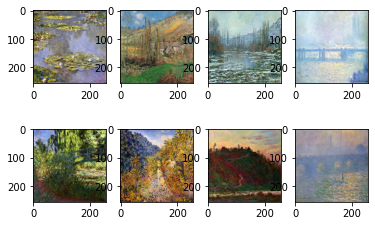

In [ ]:
image_batch = next(iter(monet_loader))

for tmpC1 in range(8):    
    img = np.moveaxis(image_batch[tmpC1].numpy(),0,2)
    plt.subplot(2,4,tmpC1+1)
    plt.imshow(img)


torch.Size([8, 3, 256, 256])


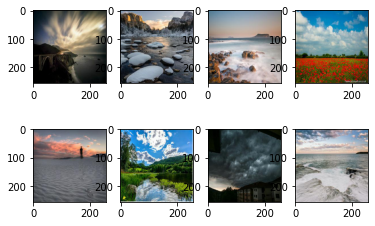

In [ ]:
image_batch = next(iter(photo_loader))
print(image_batch.shape)
for tmpC1 in range(8):    
    img = np.moveaxis(image_batch[tmpC1].numpy(),0,2)
    plt.subplot(2,4,tmpC1+1)
    plt.imshow(img)

All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

# Build the generator

We'll be using a UNET architecture for our CycleGAN. To build our generator, let's first define our `downsample` and `upsample` methods.

The `downsample`, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using an instance normalization instead of batch normalization. As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons.

Let's build our generator!

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [ ]:

class GAN_G_Model(nn.Module):
    def __init__(self, input):
        super(GAN_G_Model, self).__init__()       
        self.fc1 = nn.Linear(input, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 65536*3)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
    # forward method
    def forward(self, x): 
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        return torch.tanh(self.fc4(x))



In [ ]:
class GAN_D_Model(nn.Module):
    def __init__(self):
        super(GAN_D_Model, self).__init__()
        self.fc1 = nn.Linear(65536*3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
    # forward method
    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = F.dropout(x, 0.3)
        x = self.leaky_relu(self.fc2(x))
        x = F.dropout(x, 0.3)
        x = self.leaky_relu(self.fc3(x))
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [ ]:
def train_GAN(x): 
    #first we update the discriminator
    num_imgs = x.shape[0]
    x_real = x.view(-1, 65536*3).to(device)
    GAN_D.zero_grad()
    # train discriminator on real images
    #============================
    y_real = torch.ones(num_imgs, 1).to(device)
    D_output_real = GAN_D(x_real)
    print(D_output_real.shape)
    #recall BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))

    D_loss_real = criterion(D_output_real, y_real)


    # train discriminator on fake images
    #============================
    z = torch.randn(num_imgs, z_dim).to(device)
    x_fake = GAN_G(z)    
    y_fake = torch.zeros(num_imgs, 1).to(device)

    D_output_fake = GAN_D(x_fake)
    D_loss_fake = criterion(D_output_fake, y_fake)

    print(D_loss_real) 
    print(D_loss_fake)

    # optimize the discriminator's parameters
    D_loss_total = (D_loss_real + D_loss_fake)/2
    D_loss_total.backward()
    D_optimizer.step()
        
        
#=======================Train the generator=======================#
    GAN_G.zero_grad()

    z = torch.randn(num_imgs, z_dim).to(device)
    G_output = GAN_G(z)
    # train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
    # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
    D_output = GAN_D(G_output)
    print(D_output.shape)
    print(y_real.shape)
    G_loss = criterion(D_output, y_real)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return D_loss_total.data.item(), G_loss.data.item()

In [ ]:
GAN_G = GAN_G_Model().to(device)
GAN_D = GAN_D_Model().to(device)

In [ ]:
z_dim = 100
criterion = nn.BCELoss().to(device)
learning_rate = 0.0002 

G_optimizer = optim.Adam(GAN_G.parameters(), lr=learning_rate)
D_optimizer = optim.Adam(GAN_D.parameters(), lr=learning_rate)


In [ ]:
num_epoch = 300
D_loss, G_loss = [], []
for epoch in range(1, num_epoch+1):           

    D_losses_iter, G_losses_iter = [], []
    for batch_idx, (x) in enumerate(monet_loader):
        tmp_loss_D, tmp_loss_G = train_GAN(x)
        D_losses_iter.append(tmp_loss_D)
        G_losses_iter.append(tmp_loss_G)

    total_Loss_D = torch.mean(torch.FloatTensor(D_losses_iter))
    D_loss.append(total_Loss_D)
    total_Loss_G = torch.mean(torch.FloatTensor(G_losses_iter))
    G_loss.append(total_Loss_G)
    print('[{0:2d}/{1:2d}]: loss_d: {2:.3f}, loss_g: {3:.3f}'.format(
            epoch, num_epoch, total_Loss_D, total_Loss_G))

torch.Size([32, 1])
tensor(7.5541e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6793, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


RuntimeError: ignored

# Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [ ]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

In [ ]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

# Build the CycleGAN model

We will subclass a `tf.keras.Model` so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [ ]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=10
)

# Visualize our Monet-esque photos

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Create submission file

In [ ]:
import PIL
! mkdir ../images

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")